
# LangGraph Basics (with Gemini) — Tiny, Teachable Notebook

This mini-notebook teaches the **core ideas of LangGraph** in the shortest possible way.
You’ll build a tiny graph of nodes that:
1) takes a user question  
2) routes it either to a **calculator** (for simple math) or to **Gemini** (for general Q&A)  
3) **polishes** the final answer

> **Why LangGraph?** It helps you structure AI apps as **graphs of steps**, rather than one big prompt. That means clearer logic, easier debugging, and better control.



## 0) Setup

- **Gemini**: we'll use `google-generativeai` directly (no LangChain required, keeping it simple).  
- **LangGraph**: lightweight graph engine to wire up nodes → edges.

Run the cell below once to install dependencies (uncomment if needed).


In [1]:

# If running on a fresh environment, uncomment the next line:
!pip -q install -r requirements.txt



## 1) Add your Gemini API key

Set `GOOGLE_API_KEY` as an environment variable.  
You can paste it inline just for this notebook (okay for learning), or set it in your shell.


In [2]:

import os

# OPTION A: put your key here (for demo only)
# os.environ["GOOGLE_API_KEY"] = "your-key-here"

# OPTION B (recommended): ensure it's already set in your environment
assert "GOOGLE_API_KEY" in os.environ, "Please set GOOGLE_API_KEY (export GOOGLE_API_KEY=...) before running."
print("✅ GOOGLE_API_KEY detected")


✅ GOOGLE_API_KEY detected



## 2) Imports and tiny helpers
We'll keep **state** as a simple Python `dict`. Nodes read the dict and return an updated dict.


In [3]:

from typing import TypedDict, Optional, Literal
from typing_extensions import NotRequired
from pydantic import BaseModel
import google.generativeai as genai
import os

# Configure Gemini
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])
GEMINI_MODEL = "gemini-2.5-flash"  # fast & cheap, great for demos
model = genai.GenerativeModel(GEMINI_MODEL)

# Our app "state" (LangGraph uses dict-like state; TypedDict here is just for clarity)
class State(TypedDict, total=False):
    question: str
    route: NotRequired[Literal["calc", "llm"]]
    draft: NotRequired[str]
    final: NotRequired[str]



## 3) Define nodes (plain Python functions)

Each **node**:
- accepts the current `state` (`dict`)
- returns a (possibly) updated `state`

We'll make 4 nodes:
1. **router**: decides `"calc"` vs `"llm"`  
2. **calc_node**: does simple integer math if the user writes `math: 2+3`  
3. **llm_node**: asks Gemini to answer concisely  
4. **polish_node**: asks Gemini to shorten & tidy the final answer


In [4]:

import re

def router(state: State) -> State:
    """Decide where to go next based on the question format."""
    q = (state.get("question") or "").strip().lower()
    # Simple rule: if it starts with 'math:' we go to the calculator
    if q.startswith("math:"):
        state["route"] = "calc"
    else:
        state["route"] = "llm"
    return state


def calc_node(state: State) -> State:
    """Very naive calculator: only handles integers and + - * / ."""
    expr = state["question"].split("math:", 1)[-1].strip()
    # Keep it safe: allow only digits and basic ops
    if not re.fullmatch(r"[0-9+\-*/ ()]+", expr):
        state["draft"] = "Sorry, I only support simple integer math like 'math: 2+3*4'."
        return state

    try:
        # Evaluate safely by limiting builtins
        result = eval(expr, {"__builtins__": {}}, {})
        state["draft"] = f"Result: {result}"
    except Exception:
        state["draft"] = "I couldn't evaluate that expression."
    return state


def llm_node(state: State) -> State:
    """Ask Gemini for a short, clear answer."""
    q = state.get("question", "")
    prompt = (
        "Answer the user's question in 2-3 short sentences. Be clear and friendly.\n\n"
        f"User question: {q}"
    )
    resp = model.generate_content(prompt)
    state["draft"] = (getattr(resp, "text", "") or "").strip()
    return state


def polish_node(state: State) -> State:
    """Light polishing pass to make answers tighter."""
    draft = state.get("draft", "")
    prompt = (
        "Rewrite the following answer to be clear, concise, and beginner-friendly. "
        "Limit to ~2 sentences.\n\nAnswer:\n"
        f"{draft}"
    )
    resp = model.generate_content(prompt)
    state["final"] = (getattr(resp, "text", "") or draft).strip()
    return state



## 4) Build the graph

LangGraph wires nodes together with edges. We'll create a small graph:
```
input → router → (calc_node or llm_node) → polish_node → END
```


✅ Graph compiled


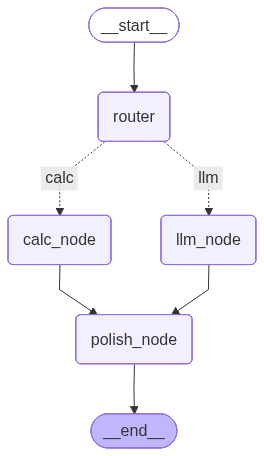

In [5]:
from langgraph.graph import StateGraph, END

graph = StateGraph(State)

graph.add_node("router", router)
graph.add_node("calc_node", calc_node)
graph.add_node("llm_node", llm_node)
graph.add_node("polish_node", polish_node)

graph.set_entry_point("router")

# 1) Return a label (not a node name)
def choose_next(state: State) -> str:
    return "calc" if state.get("route") == "calc" else "llm"

# 2) Tell LangGraph what each label maps to
graph.add_conditional_edges(
    "router",
    choose_next,
    path_map={
        "calc": "calc_node",
        "llm": "llm_node",
    },
)

# Linear edges
graph.add_edge("calc_node", "polish_node")
graph.add_edge("llm_node", "polish_node")
graph.add_edge("polish_node", END)

app = graph.compile()
print("✅ Graph compiled")

# Visualize
from IPython.display import Image, display
display(Image(data=app.get_graph().draw_mermaid_png()))



## 5) Try it out

The smart router now uses LLM to intelligently decide routing:
- **Math questions** (goes to the calculator branch)
- **General questions** (goes to Gemini)

Test with natural language - no need for "math:" prefix!


In [6]:

# Example A: math route (now using natural language)
state: State = {"question": "math: 2+3*4"}
print("Question:", state["question"])
print("Processing...")
for s in app.stream(state):
    # app.stream yields step-by-step states; we print incremental updates
    print(s)

print("\nFinal answer:", s['polish_node'].get("final"))


Question: math: 2+3*4
Processing...
{'router': {'question': 'math: 2+3*4', 'route': 'calc'}}
{'calc_node': {'question': 'math: 2+3*4', 'route': 'calc', 'draft': 'Result: 14'}}


E0000 00:00:1761085696.336052 1019526 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


{'polish_node': {'question': 'math: 2+3*4', 'route': 'calc', 'draft': 'Result: 14', 'final': 'The final answer is 14.'}}

Final answer: The final answer is 14.


In [7]:

# Example B: llm route
state: State = {"question": "What is LangGraph in simple words?"}
print("Question:", state["question"])
print("Processing...")
for s in app.stream(state):
    print(s)

print("\nFinal answer:", s['polish_node'].get("final"))


Question: What is LangGraph in simple words?
Processing...
{'router': {'question': 'What is LangGraph in simple words?', 'route': 'llm'}}
{'llm_node': {'question': 'What is LangGraph in simple words?', 'route': 'llm', 'draft': 'LangGraph is a library that helps you build sophisticated applications with Large Language Models (LLMs) by defining them as graphs. It allows you to specify a series of steps, make decisions based on outputs, and even create cycles where your application can revisit previous steps. This makes it easier to build robust, stateful agents and multi-actor systems that can perform complex tasks over time.'}}
{'polish_node': {'question': 'What is LangGraph in simple words?', 'route': 'llm', 'draft': 'LangGraph is a library that helps you build sophisticated applications with Large Language Models (LLMs) by defining them as graphs. It allows you to specify a series of steps, make decisions based on outputs, and even create cycles where your application can revisit prev


## 6) What you learned

- **State** is just a dict that flows through nodes. Each node *reads* and *updates* it.  
- **Nodes** are plain Python functions — easy to test (no magic).  
- **Routing** lets you branch logic (like a mini workflow engine).  
- **LLM calls** can live in any node (we used Gemini).  
- **Composition**: combine tools (calc) + LLM for predictable, explainable apps.

**Next steps to explore:**
- Add a **'web_search'** node for retrieval before the LLM step.  
- Add a **human approval** node (interrupt + resume) before publishing the answer.  
- Add **memory** (append conversation history to `state`).

Happy hacking! 🎉


## 7) Langgraph doesn't have a limit (Few examples)

![Example 1](https://files.realpython.com/media/Screenshot_2025-03-01_at_11.41.54_AM.7f75d6337550.png)


![Example 2](https://langchain-ai.github.io/langgraph/how-tos/assets/graph_api_image_10.png)
